In [1]:
import sys
import os

In [2]:
import datetime

In [3]:
import numpy
import scipy
import pandas

In [4]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [5]:
sys.path.append(os.path.join(os.path.abspath(os.path.join('../..')), 'src'))

In [6]:
import utils
import mysql_utils
import events_merge
import spectral_partition

In [140]:
from importlib import reload

In [141]:
reload(events_merge)

<module 'events_merge' from '/home/immersinn/gits/rssfeed_link_collector/src/events_merge.py'>

## Prelims

### Create Sequence of dates of interest

In [8]:
base = datetime.datetime.strptime('2017-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')

In [9]:
date_list = [base + datetime.timedelta(hours=x) for x in range(0, 24*7, 6)]

In [14]:
date_list[:4]

[datetime.datetime(2017, 2, 1, 0, 0),
 datetime.datetime(2017, 2, 1, 6, 0),
 datetime.datetime(2017, 2, 1, 12, 0),
 datetime.datetime(2017, 2, 1, 18, 0)]

### Get MySQL Connection, Cursor

In [115]:
cnx = mysql_utils.getCnx()

In [116]:
cur = mysql_utils.getCur(cnx)

## Communities on Single Slice

### 00: Query and Prep Data

In [75]:
details ={'summary' : {'features' : ['title', 'summary'],
                       'cutoff' : 0.15,
                       'to_binary' : False,
                       'make_symmetric' : True, 'sym_func' : lambda x,y : (x+y)/2}
         }

In [145]:
out_01 = events_merge.process_timeslice_v2(mysql_utils.query_docs_by_datetime(cursor=cur,
                                                                              start_dt=date_list[0],
                                                                              end_dt=date_list[0 + 16]),
                                           details=details)
docids = out_01['summary']['doc_ids']
ts = out_01['summary']['tslice']

#### Test on Single Slice:

In [106]:
reload(spectral_partition)

<module 'spectral_partition' from '/home/immersinn/gits/rssfeed_link_collector/src/spectral_partition.py'>

In [146]:
tsg = scipy.sparse.csr_matrix((ts['vals'], ts['ij']))

In [147]:
# Density of matrix
tsg.nnz / tsg.shape[0] ** 2

0.008934593572778827

In [148]:
tsg.shape

(1150, 1150)

In [149]:
cci = numpy.where(tsg.sum(axis=1) > 0)[0]

In [150]:
tsg_cci = tsg[cci,:][:, cci]

In [151]:
tsg_cci.shape

(937, 937)

In [152]:
groups, counts, history = spectral_partition.spectralGraphPartition23(tsg_cci, Bin='bNG', L=5, finetune=False)

In [153]:
counts

{'threeway-pair': 59, 'twoway-pair': 68, 'twoway-single': 0}

In [154]:
h2 = history.copy()

In [155]:
def reorder_history_nodes(hhh):
    """
    <Stuffs here>
    """
    order_hist = []
    n_nodes, n_levels = hhh.shape
    
    prev_grps = [0]
    for lev in range(n_levels):
        if len(prev_grps)==1:
            new_order = numpy.argsort(hhh[:,0])
            hhh = hhh[new_order,:]
            prev_grps = list(numpy.unique(hhh[:,lev]))
            order_hist.append(new_order)
        else:
            new_order = []
            new_pgs = []
            start = 0
            for grp in prev_grps:
                # Subset of nodes in "grp" from previous step
                indx = hhh[:, lev-1] == grp
                # Order subset from "grp" based on current level assignments
                # and add 
                ns = [i + start for i in list(numpy.argsort(hhh[indx,lev]))]
                new_order.extend(ns)
                new_pgs.extend(list(numpy.unique(hhh[indx,lev])))
                start += len(ns)
            hhh = hhh[new_order,:]
            prev_grps = new_pgs
            order_hist.append(new_order)
            
    return(hhh)

In [156]:
h2 = reorder_history_nodes(h2)

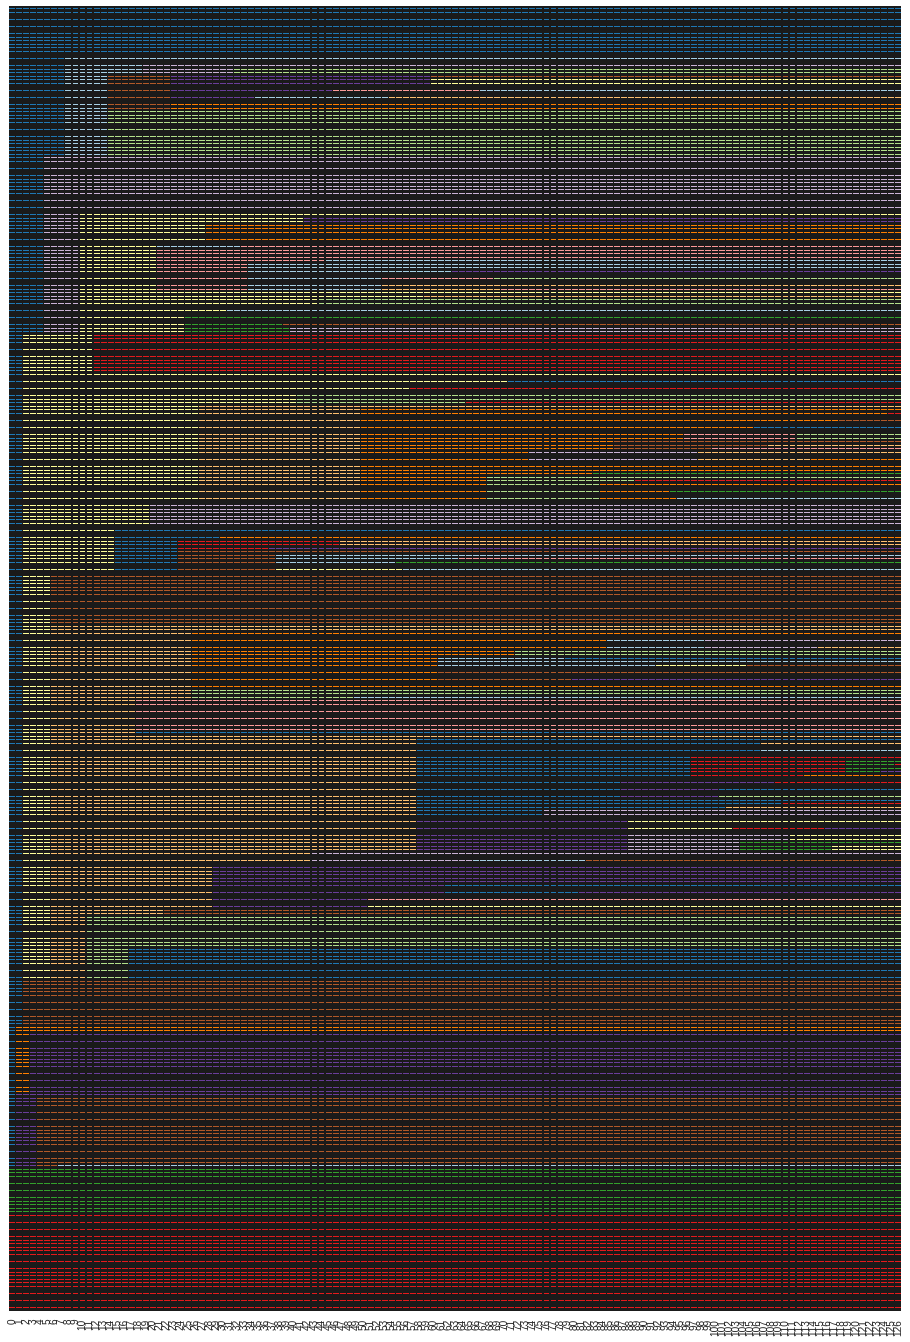

In [157]:
sns.set(style="white")

f, ax = plt.subplots()

# Draw the heatmap using seaborn
colors = sns.color_palette("Paired", n_colors=history.max())
main = [1,3,5,7,9] # "Paired"
#main = [0,1,2,3,4,5] # "bright"
nmain = [i for i in range(history.max()) if i not in main]
col, ors = [colors[i] for i in main], [colors[j] for j in nmain]
numpy.random.shuffle(ors)
colors = col; colors.extend(ors)
numpy.random.shuffle
g = sns.heatmap(h2, 
                cmap=mpl.colors.ListedColormap(colors),
                linecolor='k', linewidths=0.1,
                ax=ax, cbar=False, annot=False,
                yticklabels=False,
                );
#g.set(yticks=[]);
g.figure.set_size_inches(16, 24);

In [213]:
gps = history[:,-1]
c = 50
indxs = numpy.where(gps== c)[0]
grp = [docids[cci[i]] for i,v in enumerate((gps == c)) if v]
print(len(grp))

3


In [214]:
ddd = mysql_utils.query_docs_details(cur, grp, fields=['link', 'title', 'summary', 'published', 'rss_link'])

In [215]:
ddd[['link', 'title', 'summary']].head(15)

,link,title,summary
0,http://www.bbc.co.uk/news/health-38842561,Misophonia: Scientists crack why eating sounds...,The brains of misophonia patients like Olana a...
1,http://www.ft.com/cms/s/0/825e520c-c798-11e6-8...,Made-up men reflect changing $50bn grooming in...,Consumer goods companies from L’Oréal and Coty...
2,https://phys.org/news/2017-02-epa-oklahoma-cur...,EPA: Oklahoma regulators should do more to cur...,The Environmental Protection Agency has told O...


In [216]:
for s in ddd['title']:
    print(s)
    print('\n')

Misophonia: Scientists crack why eating sounds can make people angry


Made-up men reflect changing $50bn grooming industry


EPA: Oklahoma regulators should do more to curb earthquakes




In [217]:
for s in ddd['summary']:
    print(s)
    print('\n')

The brains of misophonia patients like Olana are hardwired to produce excessive responses, scans show.


Consumer goods companies from L’Oréal and Coty to Unilever see value in diversity


The Environmental Protection Agency has told Oklahoma regulators to do more to protect the state from a surge in earthquake activity that scientists have linked to the underground disposal of oil and gas wastewater.


